https://www.kaggle.com/code/nachiket273/cyclegan-pytorch

In [35]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

In [37]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [39]:
!export CUDA_VISIBLE_DIVICES=6

In [40]:
!echo $CUDA_VISIBLE_DIVICES

6


In [41]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [42]:
set_seed(719)

In [43]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = dict()
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [44]:
img_ds = ImageDataset('./monet_jpg/', './photo_jpg/')

In [45]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

In [46]:
photo_img, monet_img = next(iter(img_dl))

In [47]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

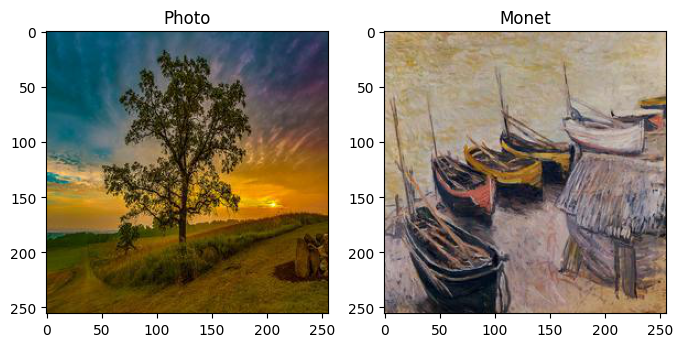

In [48]:
f = plt.figure(figsize=(8, 8))

f.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

f.add_subplot(1, 2, 2)
plt.title('Monet')
monet_img = unnorm(monet_img)
plt.imshow(monet_img[0].permute(1, 2, 0))

In [49]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt

In [50]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

In [51]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )

In [52]:
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )

In [53]:
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

In [54]:
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [55]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [56]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [57]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [58]:
# https://arxiv.org/pdf/1612.07828.pdf
# Save 50 generated fake imgs and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [59]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [60]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

In [61]:
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': gan.gen_mtp.state_dict(),
                'gen_ptm': gan.gen_ptm.state_dict(),
                'desc_m': gan.desc_m.state_dict(),
                'desc_p': gan.desc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [62]:
gan = CycleGAN(3, 3, 50, device)

In [63]:
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [64]:
save_checkpoint(save_dict, 'init.ckpt')

In [65]:
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:11.299186 | Discriminator Loss:0.846169


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:9.994203 | Discriminator Loss:0.454526


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:9.289943 | Discriminator Loss:0.428207


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:8.957466 | Discriminator Loss:0.409770


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:8.491002 | Discriminator Loss:0.394333


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:8.145741 | Discriminator Loss:0.398170


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:8.121860 | Discriminator Loss:0.399249


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:8.076298 | Discriminator Loss:0.394871


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:7.781434 | Discriminator Loss:0.399489


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:7.656358 | Discriminator Loss:0.391486


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:7.647015 | Discriminator Loss:0.404307


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:7.399164 | Discriminator Loss:0.395591


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:7.607131 | Discriminator Loss:0.393089


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:7.427933 | Discriminator Loss:0.371881


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:7.345186 | Discriminator Loss:0.364965


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:7.559115 | Discriminator Loss:0.356883


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:7.297197 | Discriminator Loss:0.360202


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:7.302217 | Discriminator Loss:0.361307


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:7.196820 | Discriminator Loss:0.350399


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:7.290883 | Discriminator Loss:0.347212


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:7.056164 | Discriminator Loss:0.343099


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:7.100046 | Discriminator Loss:0.344789


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:7.016850 | Discriminator Loss:0.327679


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:7.034638 | Discriminator Loss:0.326278


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:7.039399 | Discriminator Loss:0.313415


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:7.186247 | Discriminator Loss:0.297307


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:7.011302 | Discriminator Loss:0.277569


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:7.051558 | Discriminator Loss:0.251147


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:6.963277 | Discriminator Loss:0.231672


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:6.977984 | Discriminator Loss:0.212753


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (31) | Generator Loss:6.924579 | Discriminator Loss:0.200327


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (32) | Generator Loss:6.820956 | Discriminator Loss:0.206919


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (33) | Generator Loss:6.792252 | Discriminator Loss:0.198562


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (34) | Generator Loss:6.728205 | Discriminator Loss:0.189708


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (35) | Generator Loss:6.771481 | Discriminator Loss:0.173387


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (36) | Generator Loss:6.598537 | Discriminator Loss:0.176134


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (37) | Generator Loss:6.600991 | Discriminator Loss:0.164373


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (38) | Generator Loss:6.466436 | Discriminator Loss:0.169970


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (39) | Generator Loss:6.475230 | Discriminator Loss:0.150721


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (40) | Generator Loss:6.435893 | Discriminator Loss:0.149358


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (41) | Generator Loss:6.478124 | Discriminator Loss:0.151835


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (42) | Generator Loss:6.298058 | Discriminator Loss:0.152806


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (43) | Generator Loss:6.221144 | Discriminator Loss:0.144318


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (44) | Generator Loss:6.247461 | Discriminator Loss:0.142392


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (45) | Generator Loss:6.165706 | Discriminator Loss:0.119005


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (46) | Generator Loss:6.217737 | Discriminator Loss:0.117566


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (47) | Generator Loss:6.225823 | Discriminator Loss:0.111700


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (48) | Generator Loss:6.181795 | Discriminator Loss:0.109554


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (49) | Generator Loss:6.241888 | Discriminator Loss:0.102011


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: (50) | Generator Loss:6.205315 | Discriminator Loss:0.098968


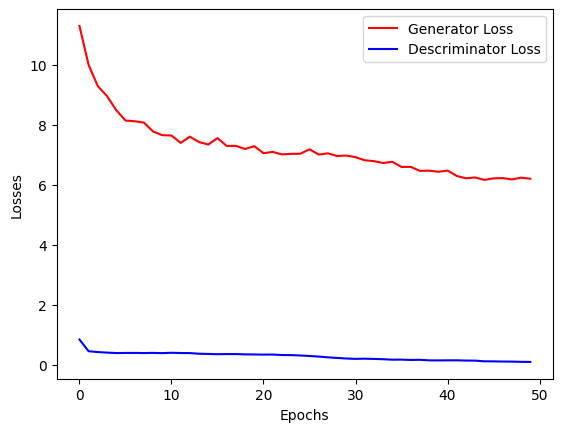

In [66]:
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
plt.legend()
plt.show()

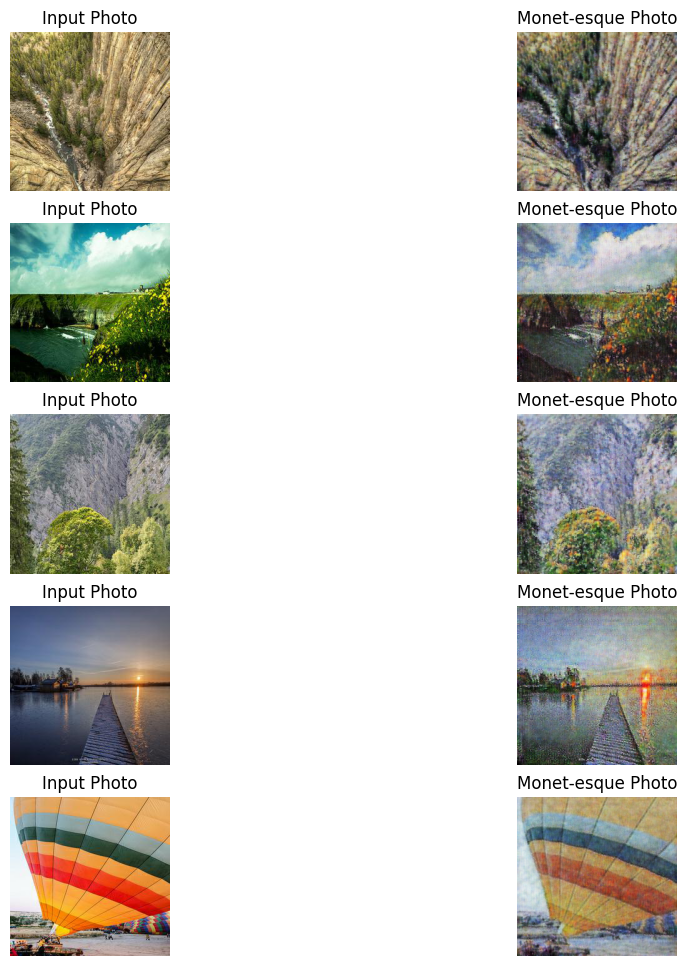

In [67]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [68]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

In [69]:
ph_ds = PhotoDataset('./photo_jpg/')


In [71]:
!mkdir ./images2


mkdir: cannot create directory ‘./images2’: File exists


In [72]:
trans = transforms.ToPILImage()


In [112]:
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save("./images2/" + str(i+1) + ".jpg")


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
shutil.make_archive("./images2", 'zip', "./images2")


In [113]:
ph_ds = PhotoDataset('./new_img/')

In [110]:
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)


In [111]:
ph_dl

In [ ]:
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    pred_monet = unnorm(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    img.save("./images2/" + str(i+1) + ".jpg")